# Create LSH dataset for testing purpose

### Import libraries

In [1]:
%matplotlib inline

import sys
sys.path.append('../')

In [2]:
import time
import pprint
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
from deeper_model import build_model
from deeper_utils import preprocess_data

Using TensorFlow backend.


### Read the dataset

In [3]:
DATASET_NAME = 'DBLP-Scholar'

In [4]:
trainData, testData, valData, embeddingMatrix, wordsWithNoEmbeddings = preprocess_data(
    DATASET_NAME, baseDir = '..', embeddingDir='fasttext-model', datasetDir='datasets', maxSequenceLength=100)

In [5]:
leftTableTrainData, rightTableTrainData, trainLabels = trainData
leftTableTestData, rightTableTestData, testLabels = testData
leftTableValData, rightTableValData, valLabels = valData

### Build the DeepER model 

In [6]:
from keras.models import load_model

model = load_model('../models/' + DATASET_NAME + '.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     4626900     input_1[0][0]                    
                                                                 input_2

### Plot DeepER architecture

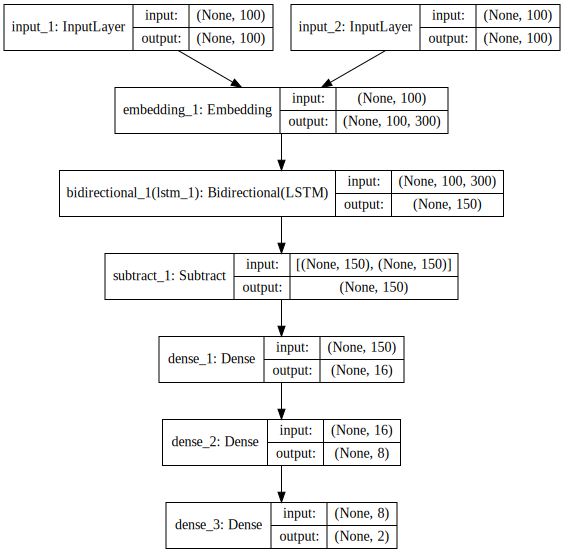

In [7]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Testing LSH
Build a new NN that given two inputs (a record from the left table and another one from the right table) outputs their corresponding embeddings.

In [8]:
import pprint

indexToLayerMap = {i: v for i, v in enumerate(model.layers)}

pprint.pprint(indexToLayerMap)

{0: <keras.engine.input_layer.InputLayer object at 0x1a27add4a8>,
 1: <keras.engine.input_layer.InputLayer object at 0x1a279dfd68>,
 2: <keras.layers.embeddings.Embedding object at 0x1a279df6d8>,
 3: <keras.layers.wrappers.Bidirectional object at 0x1a27add9b0>,
 4: <keras.layers.merge.Subtract object at 0x112aa28d0>,
 5: <keras.layers.core.Dense object at 0x112aa2898>,
 6: <keras.layers.core.Dense object at 0x1be862b0f0>,
 7: <keras.layers.core.Dense object at 0x1be862b240>}


In [9]:
from keras.models import Model

recordToEmbeddingNN = Model(inputs=model.input, 
                          outputs= [model.get_layer(index=3).get_output_at(0), model.get_layer(index=3).get_output_at(1)])

recordToEmbeddingNN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     4626900     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150)          225600      embedding_1[0][0]                
          

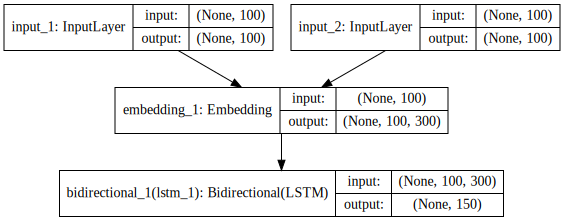

In [10]:
SVG(model_to_dot(recordToEmbeddingNN, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
predictedEmbeddings = recordToEmbeddingNN.predict(x=[leftTableTestData, rightTableTestData])

leftTableEmbeddings = predictedEmbeddings[0]
rightTableEmbeddings = predictedEmbeddings[1]

leftTableEmbeddings = leftTableEmbeddings.tolist()
rightTableEmbeddings = rightTableEmbeddings.tolist()

labels = np.argmax(testLabels, axis=1)

In [12]:
len(labels)

5742

In [13]:
lshDfDict = {"left_table": leftTableEmbeddings, "right_table": rightTableEmbeddings, "label": labels}
lshDf = pd.DataFrame(lshDfDict)
lshDf.head()

,left_table,right_table,label
0,"[0.0, 0.0, 0.9993600249290466, -0.918881118297...","[-0.0, -0.0, 0.21460436284542084, -0.984001100...",0
1,"[0.0, 0.0, 0.9993600249290466, -0.918881118297...","[-0.0, 0.0, 0.7097654938697815, 0.450796663761...",0
2,"[0.0, 0.0, 0.9993600249290466, -0.918881118297...","[-0.0, 0.0, 0.47325998544692993, -0.9972549080...",0
3,"[0.0, 0.0, 0.9993600249290466, -0.918881118297...","[-0.0, 0.0, 0.03747762367129326, -0.5199741125...",0
4,"[0.0, -0.0, -0.74958735704422, -0.999116063117...","[-0.0, 0.0, 0.03747762367129326, -0.5199741125...",0


In [14]:
lshDf.shape

(5742, 3)

In [15]:
type(lshDf['left_table'][0])

list

In [16]:
len(lshDf['left_table'][0])

150

In [17]:
lshDf.to_csv('../lsh-testing-data/' + DATASET_NAME + '-embeddings.csv', encoding='utf-8', index=False)